# Implicit Neural Representation

In this assignment, you will get some hands-on experience with implicit neural representation (INR). With INR, we parameterize some signal (in our case images) with a neural network (in this assignment, we will use a basic feed-forward network). While in practice this might be useful for outpainting, super-resolution, and compression, in this assignment we will mainly focus on the basics, with some proof-of-concept outpainting at the end. Your outputs might not look great, this is okay as long as they are at least as good as the examples.

## Dataset

As always, we start with the data. In this section, you will need to complete the following steps:

1. Choose an image. If you're working in colab, you will need to either mount your Google Drive, or else upload the file directly.
2. Write SingleImageDataset. This is how you'll convert your image into model inputs and targets. You will instantiate the dataset and a dataloader to check and make sure you did this part correctly.

### Question 1: Selecting an image (5 points)

Free points! Just show your image here. One catch- make sure the image is less than 62500 pixels, total. We do not want you to waste time waiting for your model to train.

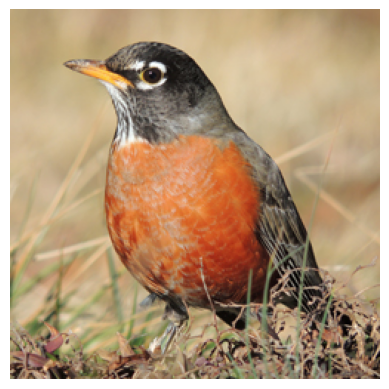

In [17]:
from torchvision.io import read_image
import matplotlib.pyplot as plt
image = read_image("bird.jpg")
plt.imshow(image.permute(1, 2, 0).numpy())
plt.axis('off')
plt.show()
plt.close()

### Question 2: Writing the dataset (20 points)

For this part, you need to fill in the blanks for the dataset provided below. Alternatively, feel free to write it from scratch, the scaffolding was provided to help you, not to trap you in a box.

You will also need to write a loop to construct the image, using a dataloader for your SingleImageDataset. We provide more details in comments below.

We will be grading your code and your image outputs. In Gradescope, make sure both are fully visible.

In [18]:
from torchvision.io import read_image
from torch.utils.data import Dataset
import numpy as np

class SingleImageDataset(Dataset):
    def __init__(self, img_path):
        self.image = read_image(img_path)
        self.num_channels, self.h, self.w = self.image.shape

    def __len__(self):
        ### TODO: 1 line of code for returning the number of pixels
        return np.prod(self.image.shape)

    def __getitem__(self, idx):
        ### TODO: 2-3 lines of code for x, y, and pixel values
        x = min(249, (idx // self.w))
        y = idx % self.w
        intensity = self.image[:, y, x].float()

        return {"x": x, "y": y, "intensity": intensity}

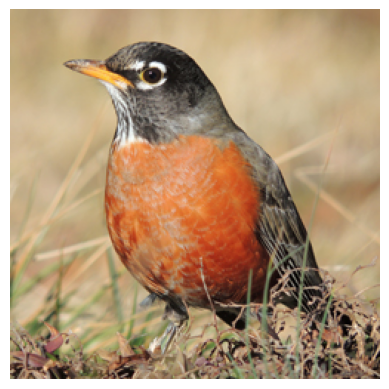

In [19]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

dataset = SingleImageDataset("bird.jpg")

### TODO: 1 line of code for initializing a DataLoader
dataloader = DataLoader(dataset, batch_size=1)

### TODO: 6-10 lines of code for using your dataloader to retrieve, reassemble,
###       and display your image
some_image = torch.zeros(image.shape)
for batch in dataloader:
    x, y, intensity = batch["x"], batch["y"], batch["intensity"]
    some_image[:, y, x] = intensity[0, :][:, np.newaxis]

plt.imshow(some_image.permute(1,2,0).numpy().astype(np.uint8))
plt.axis('off')
plt.show()

## Network


### Question 3: Defining the Network (15 points)

Define a feedforward neural network.
Remember that the last layer output dimension should be equal to the number of color channels.

A very basic network might have a linear layer, followed by a ReLU, followed by another linear layer.

In [20]:
class FFN(torch.nn.Module):
    def __init__(self):
        super(FFN, self).__init__()
        ### TODO: define and initialize some layers with weights
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(2, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 3),
        )

    def forward(self, coord):
        out = self.layers(coord)
        return out


## Training

Now that you have a dataset and model, time to put it together!

Instantiate an optimizer and a criterion.
Loop over your dataset until the network converges.
Track your loss. We will be asking you to plot it later.

In [21]:
from tqdm import tqdm

net = FFN().to('cuda')

# since we are training the network for pixels,
# we will do a pixelwise MSE loss
criterion = torch.nn.MSELoss()

### TODO: 2 lines of code for optimizer, number of epochs
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
NUM_EPOCHS = 35

dataloader = DataLoader(dataset, shuffle=True, batch_size=64)

losses = []
### TODO: set up mechanism for storing loss values
for _ in tqdm(range(NUM_EPOCHS)):
  for batch in dataloader:
      x, y, actual = batch["x"].to('cuda'), batch["y"].to('cuda'), batch["intensity"].to('cuda')
      x = x / dataset.w # normalizing x between 0 and 1
      y = y / dataset.h # normalizing y between 0 and 1
      ### TODO: 3 lines of code to assemble coord from x and y, pass to net,
    ###       compute loss
      coord = torch.stack((x, y), dim=-1)
      pred = net.forward(coord)
      loss = criterion(pred, actual)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
  # print(loss.item())
  losses.append(loss.item())

100%|██████████| 35/35 [06:44<00:00, 11.55s/it]


### Question 4: Plot loss over time (20 points)

For this part, plot your loss from training the model.

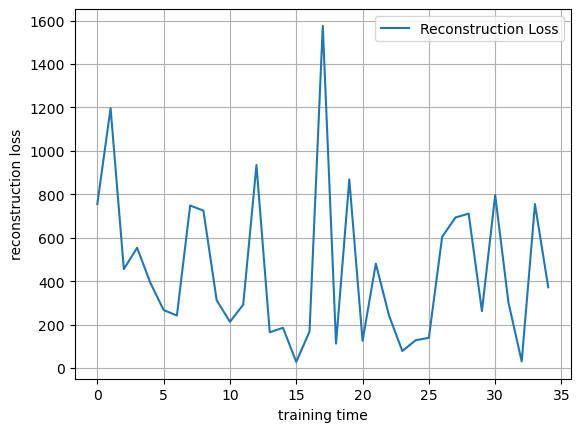

In [22]:
### TODO: make plot of reconstruction loss (y-axis) over training time (x-axis)
plt.plot(range(len(losses)), losses, label='Reconstruction Loss')
plt.xlabel('training time')
plt.ylabel('reconstruction loss')
plt.legend()
plt.grid(True)
plt.show()

## Evaluation

### Question 5: Reconstruct whole image (20 points)

For this part, reconstruct the image using your model's outputs, at each coordinate.
You can use our scaffolding code, or write your own.
For this part, we are just grading the image plot, where you should plot the original image side-by-side with the reconstruction, as shown in this example.

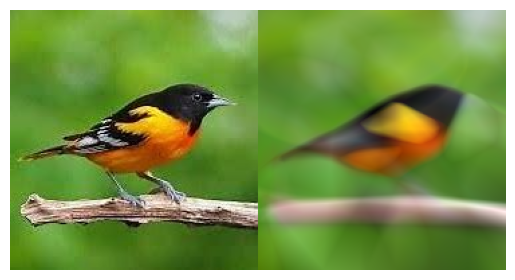

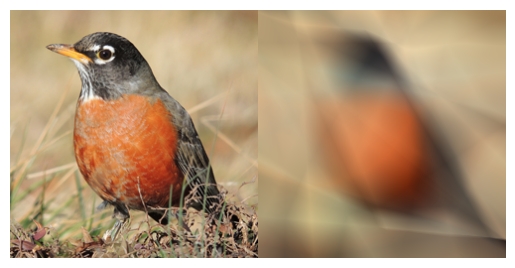

In [23]:
### TODO: ~12 lines of code to assemble gt_image, build pred_image
###       from model
pred_image = torch.zeros((3, 250, 250))

x = torch.arange(0, 250, dtype=torch.float, device='cuda')
y = torch.arange(0, 250, dtype=torch.float, device='cuda')
coord = torch.stack(torch.meshgrid(x/250, y/250), dim=-1)
predictions = net(coord)
pred_image = predictions.permute(2, 1, 0)

joint_image = torch.cat([some_image, pred_image.cpu()], dim=2)
plt.imshow(joint_image.detach().permute(1, 2, 0).numpy().astype(np.uint8))
plt.axis('off')
plt.show()
plt.close()

### Question 6: Compute PSNR (10 points)

For this part, print the PSNR for your reconstruction vs. the original image. Feel free to use any libraries, or implement it from scratch.

In [24]:
# Note: picked from GFG
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

In [25]:
### TODO: compute and print PSNR between reconstructed (predicted) and ground truth images
PSNR(some_image.detach().numpy(), pred_image.cpu().detach().numpy())

19.492436121470668

### Question 7: Outpainting (10 points)

INR is a continuous image representation. What happens if your input coordinates don't correspond to real pixels? Try it out and show the result!

For this part, have your model predict 20 pixels in all directions that are outside the boundaries of the original image, and show the resulting image below. Also plot a box around the region corresponding to the original image, for clarity.

We show an example below.

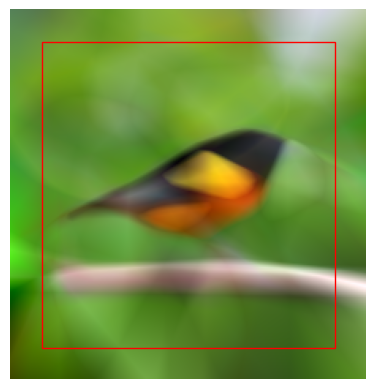

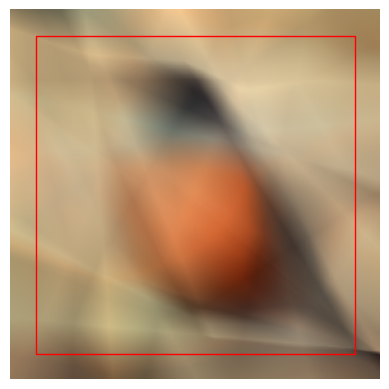

In [26]:
import matplotlib.patches as patches

### TODO: 6-10 lines of code to generate outpainted image
x_range = np.arange(-20, image.shape[2] + 20)
y_range = np.arange(-20, image.shape[1] + 20)
xv, yv = np.meshgrid(x_range, y_range)
coords = np.stack([xv / (image.shape[2] + 19), yv / (image.shape[1] + 19)], axis=-1)
coords = torch.tensor(coords, dtype=torch.float32).to('cuda')
outpainted_image = net(coords)
outpainted_image = outpainted_image.view(image.shape[1] + 40, image.shape[2] + 40, image.shape[0])

fig, ax = plt.subplots()
ax.imshow(outpainted_image.detach().cpu().numpy().astype(np.uint8))
rect = patches.Rectangle((20, 20), dataset.w, dataset.h, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.axis('off')
plt.show()
plt.close()